# Working directly with the Omeka S Backend
Opening efforts to directly access and use the data in an Omeka S site. See http://epoehler.umasscreate.net/pbmp for the front-end.

In [1]:
from fastnumbers import fast_real, isreal
import pymysql.cursors
import pandas as pd
import rdflib
from rdflib import URIRef, BNode, Literal, Namespace

# display settings
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
db_params = open("mysql.txt").read().split() # a file on local storage that should never be pushed to a public repo

In [3]:
# Connect to the database

connection = pymysql.connect(host=db_params[0],
                             user=db_params[1],
                             password=db_params[2],
                             db=db_params[3],
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

## 'values' table to triples (in progress)
The Omeka S database has a 'values' table that is roughly a translation of the data about items into a triple-like structure. It's very useful but is both very normalized and relies on integer unique ids, not human-readable labels. That's a solid approach for the backend.

This is a first go at a single SQL SELECT query that moves the 'values' table towards actual RDF-serialized triples. It's working but I'm sure could be more efficient.

In [4]:
sql = """SELECT subjects.subject,
                subjects.predicate,
                subjects.object_literal,
                subjects.object_uri,
                omeka_uris.object_omeka_id 

         FROM
        
         (SELECT ids.value AS subject,
                CONCAT(vocabulary.namespace_uri, property.local_name) as predicate,
                value.value AS object_literal,
                value.uri AS object_uri,
                value.value_resource_id
         
           FROM   value,
                (SELECT value,resource_id FROM value as v2 WHERE v2.property_id = 10) AS ids,
                (SELECT v3.resource_id,v4.value 
                   FROM value AS v3, value as v4
                   WHERE v3.property_id = 185
                   AND v3.value_resource_id = v4.resource_id AND v4.property_id = 10) AS types,
                property,
                vocabulary
                
           WHERE value.property_id = property.id
               AND value.resource_id = ids.resource_id
               AND value.resource_id = types.resource_id
               AND property.local_name <> 'identifier'
               AND property.vocabulary_id = vocabulary.id) AS subjects
        
        LEFT JOIN
        
         (SELECT ids.value as subject,
                CONCAT(vocabulary.namespace_uri, property.local_name) AS predicate,
                v4.value AS object_omeka_id
           FROM value,
              value AS v4,
              vocabulary,
              (SELECT value,resource_id FROM value AS v2 WHERE v2.property_id = 10) AS ids,
              property WHERE v4.property_id = 10 AND
                  value.value_resource_id = v4.resource_id AND
                  value.property_id = property.id AND
                  value.resource_id = ids.resource_id AND
                  property.vocabulary_id = vocabulary.id) AS omeka_uris

        ON subjects.subject = omeka_uris.subject AND subjects.predicate = omeka_uris.predicate"""

pbmp_triples_df = pd.read_sql(sql,connection)

In [5]:
# pbmp_triples_df is now recognizable as an idiosyncratic representation of RDF triples.
# The object_* columns need to be processed, but that will happen in the context of loading
# into a graph and/or triplestore with rdflib
pbmp_triples_df.head() 

,subject,predicate,object_literal,object_uri,object_omeka_id
0,pompeii,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,None,None,archaeological-site
1,pompeii,http://purl.org/dc/terms/title,The Archaeological Site of Pompeii,None,None
2,pompeii,http://www.w3.org/2000/01/rdf-schema#seeAlso,Pompeii-in-Pictures,http://pompeiiinpictures.com/,None
3,pompeii,http://www.w3.org/2000/01/rdf-schema#seeAlso,Pleiades,https://pleiades.stoa.org/places/433032,None
4,pompeii,http://www.w3.org/2000/01/rdf-schema#seeAlso,Getty LOD,http://vocab.getty.edu/tgn/7004658,None


In [7]:
# initialize graph

plod_ns = 'http://plod.umass.edu/plod/id/'

g = rdflib.Graph()
g.bind('plod',plod_ns)
g.bind('dcterms','http://purl.org/dc/terms/')
g.bind('vra','http://purl.org/vra/')


# iterate over each row and add resulting triple to graph.
for index,row in pbmp_triples_df.iterrows():
    # this is straightforward, just needs an actual URI pattern
    s = URIRef("{}{}".format(plod_ns,row[0]))
    # also straightforward as the DF holds fully qualified URIs for predicates
    p = URIRef(row[1])
    
    # here's where the (manageable) complexity is
    if row[3]:
        # it's a external URI reference
        o = URIRef(row[3])
    elif row[2]:
        # it's a literal. For now, everything is a string. Parsing of literal types to come...
        if isreal(row[2]):
            o = Literal(fast_real(row[2]))
        else:
            o = Literal(row[2])
    elif row[4]:
        # it's a reference to a plod resource. Parsing of Class or NamedIndividual to come...
        o = URIRef("{}{}".format(plod_ns,row[4]))
    else:
        o = Literal("__PROBLEM__")
    
    g.add((s,p,o))


In [8]:
turtle = g.serialize(format="turtle")

# g.serialize(format="turtle")

g.serialize(destination='plod.ttl', format='turtle')

## Basic Reporting

In [9]:
# what is the max number of triples associated with any subject
pbmp_triples_df.groupby(by="subject").count().max()

predicate          18
object_literal      8
object_uri          3
object_omeka_id     8
dtype: int64

In [10]:
# number of items about which PBMP makes statements
pbmp_triples_df.subject.nunique()

1189

In [11]:
# how many statements/"triples"
len(pbmp_triples_df)

8343

In [12]:
# when the main SQL  query is working, this will be a bar chart of 'types'. As in, how many

### Areas

In [13]:
pbmp_areas = pbmp_triples_df.query("predicate == 'http://purl.org/vra/area'")[['subject','object_literal']]
pbmp_areas['area'] = pbmp_areas['object_literal'].astype(float)

pbmp_areas.describe()

,area
count,1161.000000
mean,313.229701
std,840.695221
min,2.337489
25%,31.824169
50%,89.448195
75%,326.279837
max,16609.395420


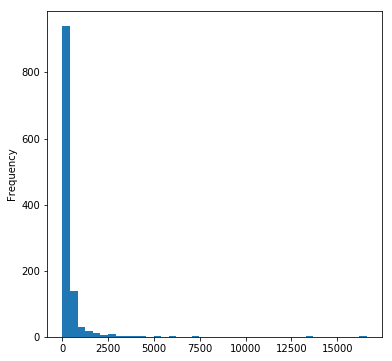

In [14]:
# simple histogram of all areas
pbmp_areas['area'].plot.hist(bins = 40, figsize = (6,6))

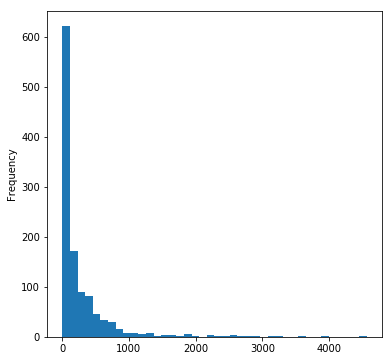

In [15]:
# simple histogram of areas less than or equal to 5000
pbmp_areas.query("area <= 5000").area.plot.hist(bins = 40, figsize = (6,6))

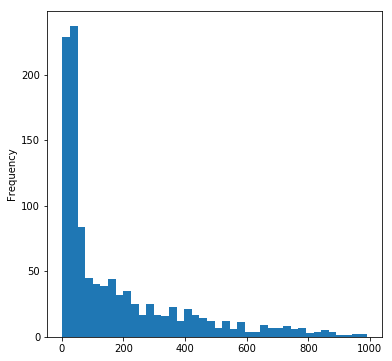

In [16]:
# simple histogram of areas less than or equal to 1000
pbmp_areas.query("area <= 1000").area.plot.hist(bins = 40, figsize = (6,6))

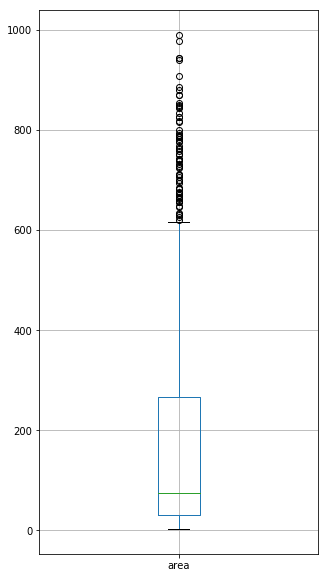

In [17]:
# a boxplot. Will be interesing to look at properties between 600 and 1000. How much
# diversity in that set. And everything else!
pbmp_areas.query("area <= 1000").boxplot(figsize=(5,10))

In [18]:
# largest  areas
pbmp_areas.sort_values('area', ascending = False).head(5)

,subject,object_literal,area
1489,r2-i7-p9,16609.39542,16609.395420
1482,r2-i6-p1,13293.1957,13293.195700
7176,r7-i8-p1,7211.412942,7211.412942
1475,r2-i5-p2,6195.953697,6195.953697
1468,r2-i4-p6,5848.017777,5848.017777


In [19]:
# smallest areas
pbmp_areas.sort_values('area', ascending = True).head(5)

,subject,object_literal,area
2270,r9-i11-p7,2.337489069,2.337489
3046,r9-i7-p6,2.544309543,2.544310
6644,r7-i4-p5,2.642611718,2.642612
3067,r9-i7-p9,2.694757373,2.694757
3025,r9-i7-p3,3.149093733,3.149094


## Direct links to Omeka S Items on the basis of dcterms:identifier
This is going to be a hack. But it will move towards using cleaner URLs over time.

In [20]:
link_template = '<a target="_new" href="http://epoehler.umasscreate.net/pbmp/s/pbmp-items/item?property%5B0%5D%5Bjoiner%5D=and&property%5B0%5D%5Bproperty%5D=10&property%5B0%5D%5Btype%5D=eq&property%5B0%5D%5Btext%5D={0}&property%5B1%5D%5Bjoiner%5D=and&property%5B1%5D%5Bproperty%5D=&property%5B1%5D%5Btype%5D=eq&property%5B1%5D%5Btext%5D=&site_id=&item_set_id%5B%5D=&submit=Search">{0}</a>'

display(HTML("""<p><b>The Largest Properties by Area</b></p>
                <p>Link is currently to search results, which is annoying.</p>"""))
for index,link_me in pbmp_areas.sort_values('area', ascending = False).head(5).iterrows():
    #print(link_template.format("r9-i11-p7"))
    display(HTML(link_template.format(link_me[0])))

